# 6 Dynamic Optimisation

In the lecture we have learned analytic methods to solve optimal control problems, i.e. we solved them using purely mathematical techniques, with pen and paper. Many problems may however not be analytically solvable, if the problems become more complex. In that case, we resort to numerical optimisation methods. The advantage of using a computer is that we can run thousands of calculations in a very short time, so it allows us to try out a certain time path for our control and state variables, and then iterate towards some optimal solution. The key challenge is to design methods that converge relatively fast, i.e. with relatively few steps of calculation. Much of the explanation in this tutorial, as well as the practice problem is based on Sharp et al. (2021), which is a good overview of the basic method, as well as a few extensions to it.

In this tutorial, you will learn to implement one such algorithm, the forward-backward-sweep method. There are many possible variations and extensions of it, but if you understand the principles of the core framework, it should be relatively easy for you to learn how to implement those by yourselves. The algorithm essentially starts with a "guess" about the optimal solution for the control variable, and based on this guess then iterates the state variable forward in time, starting from the initial condition $x(0)=x_0$. This is a straightforward application of any timestepping scheme from the previous tutorials (in practice typically the fourth-order Runge-Kutta) on the state equation. In case there is no terminal condition (and if it is relatively clear that $x(T) \neq 0$), we can then iterate the co-state variable, the shadow price, *backwards* from $\mu(T)=0$. Similarly, if a final function $F(x(T), T)$ is given, we know that $\mu(T) = \frac{\partial F}{\partial x}_{t=T}$, so we iterate backwards from that value. This provides initial guesses for the state and co-state variables, which might be far from the optimal solution still. However, we can, based on these guesses and the first-order conditions, optimise the control variable and improve upon this first guess of the control variable. With this improved guess we can now start from the beginning and run these three steps (forward iteration of state variable, backward iteration of co-state, optimisation of control) over and over again until the algorithm converges. If a desired terminal state $x(T)=x_T$ is given, or if it is not quite clear whether $\mu(T)=0$ or $x(T)=0$ (recall the condition $x(T)\mu(T)=0$ in absence of a terminal condition), other methods need to be added. This tutorial is only meant to be a brief and gentle introduction to the topic however, so we will focus on the most basic version, where $\mu(T)=0$.

While quite a few steps are involved in solving this problem, it is mainly a combination of techniques we already know from the previous tutorials. We will take it step by step to keep it as simple as possible. 

Rather than viewing the one algorithm here as a go-to solution for any optimisation problem you may come across in the future (other classes, thesis, work...), this should serve as an introduction to the general idea of iteratively searching for an optimal solution to a given problem, be it optimisation, estimation, or anything else. After all, the general idea of starting from a (random) initial guess and to somehow converge to an optimum applies not only to our abstract academic problems in class, but also forms the core of many machine learning algorithms.


###### REFERENCE:

Sharp JA, Burrage K, Simpson MJ, 2021. Implementation and acceleration of optimal control for systems biology. *J. R. Soc. Interace* **18**: 20210241. https://doi.org/10.1098/rsif.2021.0241.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

# this renders text in figures in Latex font
from matplotlib import rc
rc('text', usetex=True)

### Free terminal state

Consider the optimisation problem 

$\begin{align}
    \text{max } J &= \int_{t_0}^{T} I\left(x, u, t\right) + \phi\left(x_T, T\right) \\
    x' &= f\left(x, u, t\right) \\
    x_0 &= 0
\end{align}$

Where $x$ is the state variable, $u$ the control, $I(\cdot)$ is the influence function, $\phi(\cdot)$ is the final function (not always given), and $f(\cdot)$ is the law of motion, i.e. the state equation. The Hamiltonian is

$\begin{equation}
    H = I\left(x, u, t\right) + \mu\left(f\left(x, u, t\right)\right)
\end{equation}$

and we know the first-order conditions (FOCs):

$\begin{align}
    \nonumber\frac{\partial H}{\partial u} &\overset{!}{=} 0 \hspace{0.5cm}(i)\\
    \nonumber\frac{\partial H}{\partial x} &\overset{!}{=} -\mu' \hspace{0.5cm}(ii)\\
    \nonumber\frac{\partial H}{\partial \mu} &\overset{!}{=} x' \hspace{0.5cm}(iii)\\
    \nonumber\frac{\partial \phi}{\partial x(T)} &\overset{!}{=} \mu(T)  \hspace{0.5cm}(iv)
\end{align}$

If no final function is given, the last condition becomes

$\begin{equation}
    \mu(T)x(T) = 0 \Leftrightarrow \mu(T)=0\lor x(T)=0
\end{equation}$

To solve this numerically, we first have to discretise the continuous-time system, creating $N+1$ points in time, with $dt=\frac{T-t_0}{N}$. Now we start with an initial guess for the time path of the control variable $u^{(0)}$ (superscript denotes iteration number of our algorithm) and use this guess to solve the dynamics of the state variable $x$ *forward* in time, starting from the initial condition. We can use any of the methods from the last three tutorials, but the Runge-Kutta timestepping methods is really the standard here. Having solved the time path of the state variable, and given our initial guess of the control variable, we can now use the $(ii)$, with a starting value from $(iv)$ to solve the time path of $\mu$ *backwards*. 

At this point we have the initial guesses for the time paths of all three variables of interest. However, there is no reason to assume that this initial guess is actually optimal. Hence, we can use FOC $(i)$ to satisfy the optimality condition of our control variable $u$. This can be done with a simple Newton-type method of finding the roots of an equation. As we are finding the roots of the derivative, it means we will ultimately find a (local) optimum. In practice, it means that we iterate through the values of $u(t), t\in[0, dt, ..., T]$, solve for the roots of the FOC at that point in time, and update our guess to $u^{(1)}$. Often, we do not step fully towards the optimum, but only some part of the way, i.e. we set $u^{(k+1)} \leftarrow (1-\omega) u^{(k)} + \omega \hat{u}^{(k+1)}$. This avoids potential instability in the convergence behaviour through overshooting.

We can then start over with this updated guess $u^{(1)}$ for the control variable to re-estimate the time paths for $x$ and $\mu$ and proceed through the same steps over and over again. We stop when some convergence criterion has been reached, or when we meet a maximum number of iterations, which we typically set in case we cannot reach convergence (we do not want the computer to run forever).

As you can see, there are quite a few steps involved, but we will break up the problem into smaller components and go through it step by step. Many of the methods we use are already known to you by now, so I hope the combination of several of these does not appear too daunting at this point. First, we set up a Hamiltonian, then write functions to differentiate numerically, create the timestepping functions for $x$ and $\mu$ using the fourth-order Runge-Kutta iterator, and then we implement the Newton algorithm to optimise the control variable. Finally, we put it all together to solve the problem that is given below.

Everything will be implemented quite generally, so that the program should be able to solve any other optimisation problem where $\mu(T)=0$. You only have to adjust the Hamiltonian and the state equation.

### Optimisation problem

As am example we use the farming problem from Sharp et al. (2021). There is a single crop on a field, of which we denote the amount at time $t$ by $x(t)$. The control, e.g. fertilizer to spur growth, is denoted by $u(t)$. We start with an initial amount (small plants at the beginning of the season) $x(0) = x_0$ and have an indeterminate (free) final state $x(T)$ at the end of the growing season. Hence, we want to grow as much as is economically optimal. The condition $x(T)\mu(T)=0$ then logically implies that $\mu(T)=0$, as it cannot be optimal to not have anything to harvest ($x(T)=0$).

Plants grow better with more fertilizer, leading to the state equation

$\begin{equation}
    \frac{dx}{dt} = \gamma x(t) + u(t) 
\end{equation}$

with $x(0)=x_0$. We maximise profit: revenue from harvest sales minus costs of fertilizer. As the growth depends on current size of plants and the amount of fertilizer now, this is a dynamic problem with the objective function

$\begin{equation}
    \text{max } J = \int_0^1 \left(ax^2 - bu^2\right) dt
\end{equation}$

We set the length of one season to 1, so that the integral is from $t=0$ to $t=1$. Both revenue and costs are quadratic. The analytical solution is quite cumbersome (provided in the online appendix by Sharp et al. (2021)), so it is better to solve it numerically. Let us take it step by step.


##### EXERCISE

In the first step, set up the Hamiltonian function and implement it below. Implement the state equation $\frac{\partial x}{\partial t} = f(x, u, t)$ as well! Use the parameter values $a=b=1$ and $\gamma = 0.5$.

##### SOLUTION

The Hamiltonian is given by (supressing time indices):

$\begin{equation}
    H = ax^2 - bu^2 + \mu(\gamma x + u)
\end{equation}$

Implementing it simply means typing this equation, as below. The state equation can also be typed in a straightforward manner.

In [2]:
def Hamiltonian(x, u, mu, t):
    return x * (x + 0.5 * mu) + u * (mu - u)

def dxdt(x, u, t):
    return 0.5 * x + u

### Numerical differencing

It was introduced as a bonus exercise in the previous tutorial, but now you cannot avoid it anymore. Recall the principles that were discussed:

Sometimes the derivative of a function may not be easy to calculate, or you don't know the exact function of the dynamic model you are analysing. That can be particularly relevant when you are working with empirical data for which you do not know the exact data-generating function. In that case, numerical differencing comes in handy. Consider the definition of derivatives:

$f'(x) = \underset{\epsilon\rightarrow0}{lim}\frac{f(x+\epsilon) - f(x)}{\epsilon}$. 

We cannot actually implement infinitesimally small steps, but we can approximate derivatives with finite differences, using finitely small values of $\epsilon$:

$f'(x)\approx\frac{f(x+\epsilon) - f(x)}{\epsilon}; \hspace{0.5cm}\epsilon>0$.

We can use forward or backwards differencing ($+\epsilon$ or $-\epsilon$), but a good option is usually central differences:

$f'(x)\approx\frac{f(x+\frac{\epsilon}{2}) - f(x-\frac{\epsilon}{2})}{\epsilon}$.

Since we have to evaluate the function at two points anyway, this does not come at a significantly higher computational cost either.

##### EXERCISE

Complete the two functions $\frac{\partial H}{\partial u}$ and $\frac{\partial H}{\partial x}$ using numerical differencing (central difference quotient) below. `H` is the Hamiltonian function, which we defined above (and which can be exchanged flexibly if the problem changes), `x`, `u`, `𝜇`, `t` are following the standard notation of the course. They represent the point at which the function is to be evaluated. Finally, `eps` is the parameter that defines the size of the difference we will evaluate, $\epsilon$ in the description above. We do not need to differentiate with respect to $\mu$, since it only leads to the state equation, which we know already.

##### SOLUTION

Using final differences, we will evaluate the Hamiltonian at points $\epsilon/2$ above and below the point of interest (along the axis that we differentiate) and divide by the length $\epsilon$. In the case of the derivative with respect to $u$, that means we calculate

$\begin{equation}
    \frac{\partial H}{\partial u}\approx\frac{H(x, u+\epsilon/2, \mu, t) - H(x, u-\epsilon/2, \mu, t)}{\epsilon}
\end{equation}$

In [3]:
def dHdu(H, x, u, mu, t, eps):
    return (H(x, u + 0.5 * eps, mu, t)- H(x, u - 0.5 * eps, mu, t)) / eps

def dHdx(H, x, u, mu, t, eps):
    return (H(x + 0.5 * eps, u, mu, t) - H(x - 0.5 * eps, u, mu, t)) / eps

##### EXERCISE

Next, complete the two functions below. They perform a single Runge-Kutta step in the variables $x$ and $\mu$. Note that the step in $\mu$ is *backwards* in time. The time derivative of $\mu$ is given by the second FOC of the Hamiltonian.

##### SOLUTION

The Runge-Kutta timestepping method should be known from the last tutorial. The only added challenge here is that $\mu$ is iterated backwards. That simply means that we will subtract the rate of change, rather than adding it:

$\begin{equation}
    \mu_{k-1} = \mu_k - \frac{\delta}{6} \left(k_1 + 2k_2 + 2k_3 + k_4\right)
\end{equation}$

where $k_{2,3,4}$ are also calculated backwards, i.e. subtracting differences instead of adding. We do not need to take care of this explicitly though, since we calculate the negative time derivative through the second FOC.

In [4]:
def xRK_1step(x, u, t, dt):
    k1 = dxdt(x, u, t)
    k2 = dxdt(x + dt * k1 * 0.5, u, t)
    k3 = dxdt(x + dt * k2 * 0.5, u, t)
    k4 = dxdt(x + dt * k3, u, t)
    return x + (dt / 6) * (k1 + 2 * (k2 + k3) + k4)

def muRK_1step(H, x, u, mu, t, dt, eps):
    k1 = dHdx(H, x, u, mu, t, eps)
    k2 = dHdx(H, x + dt * k1 * 0.5, u, mu, t, eps)
    k3 = dHdx(H, x + dt * k2 * 0.5, u, mu, t, eps)
    k4 = dHdx(H, x + dt * k3, u, mu, t, eps)
    return mu + (dt / 6) * (k1 + 2 * (k2 + k3) + k4)

The next set of functions we need is the implementation of the Newton method to optimise our control, given our time paths of $x$ and $\mu$ (which were calculated with the last guess of the control variable). We will use Newton's algorithm again, applying it independently to the values of our control variable at every point in time. Note that we look for the roots of the derivative of the Hamiltonian with respect to the control variable, so we will also need the next higher (second-order) derivative. 

##### EXERCISE

Calculate the second derivative of the Hamiltonian with respect to $u$ ($\frac{\partial^2 H}{\partial u^2}$), using numerical differencing.

##### SOLUTION

All we have to do is differentiate the differences, apply the function from above:

In [5]:
def d2Hdu2(H, x, u, mu, t, eps):
    return (dHdu(H, x, u + 0.5 * eps, mu, t, eps) - dHdu(H, x, u - 0.5 * eps, mu, t, eps)) / eps

##### EXERCISE

Now implement Newton's method on a single value $u$ at one point in time

##### SOLUTION



In [6]:
def uNewton(H, x, u, mu, t):
    '''
    Find the optimal value of the control variable u at one point in time
    using Newton's method.
    
    Critical values to determine satisfactory convergence or iteration
    limits are defined in the function to reduce the amount of inputs.
    Note that in your own applications, it might make sense to designate 
    them as input variables.
    
    Inputs:
        H: function object to specify the Hamiltonian
        x: value of state variable 
        u: initial value u
        mu: value of co-state variable (shadow price)
        t: time index (in case it matters, e.g. when discounting is involved)
        
    Output:
        optimal value for control variable u, given the other variables
    '''
    crit = 1e-6      # critical value for convergence
    max_iter = 100   # maximum amount of iterations
    eps = 0.01       # step size in numerical differencing scheme
    for i in range(max_iter):
        # single Newton step
        u = u - (dHdu(H, x, u, mu, t, eps) / d2Hdu2(H, x, u, mu, t, eps))
        # check convergence criterion
        if abs(dHdu(H, x, u, mu, t, eps)) < crit:
            break
    # return updated control u 
    return u

##### EXERCISE

And finally, update all values in the array of $u$ to the improved guess, simply iterating through the array. Do not use the output of Newton's method $\hat{u}^{(k+1)}$, but the weighted average $u^{(k+1)} = (1-\omega) u^{(k)} + \omega \hat{u}^{(k+1)}$. Only moving part of the way towards the optimal guess can improve stability of the algorithm (less overshooting).

##### SOLUTION

In [7]:
def update_control(H, X, U, Mu, T, omega):
    '''
    Update the entire array of control variable values.
    
    Imputs:
        H: Hamiltonian function object
        X: array of state variable x values
        U: array of last iterations best guess of control variables u values
        Mu: array of co-state variable values
        T: time array
        omega: step size towards new optimal guess with 0<omega<1
        
    Output:
        updated best guess for control variable array U
    '''
    for i, u in enumerate(U):
        U[i] = (1 - omega) * u + omega * uNewton(H, X[i], u, Mu[i], T[i])
    return U

Finally, we simply put it all together. The function below first defines some variables and arrays. The arrays of the state and co-state are empty for now, while the control variable is an array of zeros. Then we start our iterative algorithm: first create the time series of the state variable, iterating it forward with `N` Runge-Kutta steps, then we do the same backwards for the co-state. Before we optimise the control variable we store the current value in a separate array as a copy, so once it is optimised, we can compare and check if they differ at all. If they are extremely similar (here we check the Euclidean norm of the difference of both "vectors"), we conclude that the algorithm has converged and break out of the loop. Finally, we return the result.

In [8]:
def optimize(H, x0, dt, T):
    '''
    Optimization function to implement the forward-backward-sweep method 
    for cases where the transversality condition mu(T)=0 applies.
    
    Final time T is set to 1.
    
    Convergence is considered achieved when the optimal guess in the control
    variable does not change considerably anymore. To measure this change,
    we use the Euclidean norm of the difference between the old and new 
    optimal time series arrays of u.
    
    Inputs:
        H: Hamiltonian function object
        x0: initial state of state variable x
        dt: size of time increment (subject to adjustments so equal steps 
            can be guaranteed)
            
    Outputs:
        x: state variable time series
        u: control variable time series
        mu: co-state time series
    '''
    # these could be function inputs as well:
    max_iter = 1000
    omega = 0.5
    eps = 0.01
    
    # initialise some variables and arrays
    N = int(1 / dt)              # number of time steps, as an integer
    dt = 1 / N                   # adjust dt to fit into interval
    t = np.linspace(0, T, N+1)   # time array
    x = np.empty(N+1)            # state variable array (empty at first)
    x[0] = x0                    # first entry is the initial state
    mu = np.empty(N+1)           # empty array for co-state (shadow price)
    mu[-1] = 0                   # last entry is 0 
    u = np.zeros(N+1)            # intial guess for control variable: array of zeros
  
    # start iterating to update u
    for i in range(max_iter):
        # create time series of state and costate based on u
        for i in range(N):
            x[i+1] = xRK_1step(x[i], u[i], t[i], dt)
        for i in range(N, 0, -1):
            mu[i-1] = muRK_1step(H, x[i], u[i], mu[i], t[i], dt, eps)
        
        # store last value of u for comparison afterwards
        u_old = u.copy()
        # new control guess
        u = update_control(H, x, u, mu, t, omega)
          
        # stopping criterion
        if np.linalg.norm(u - u_old) < 1e-10:
            print(f"convergence after {i+1} iterations")
            break
            
    return x, u, mu

In [9]:
x0 = 1
T = 1
dt = 1/(2**10)

x, u, mu = optimize(Hamiltonian, x0, dt, T)

convergence after 2 iterations


Find below a graphical representation of the optimal solutions of state and control variables:

<IPython.core.display.Javascript object>


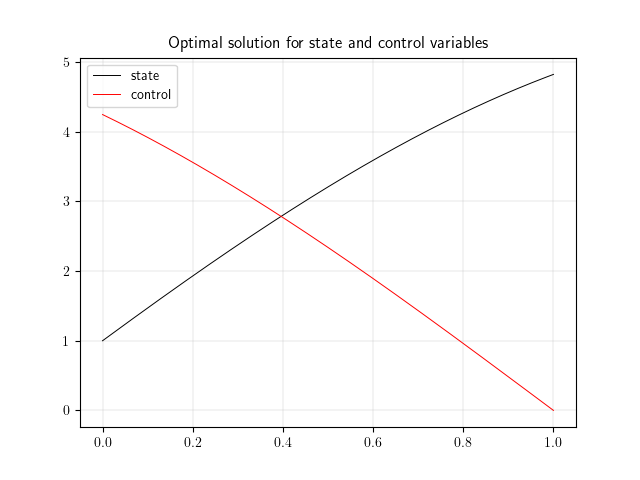

In [10]:
plt.figure()

plt.title("Optimal solution for state and control variables")

t = np.linspace(0, T, len(x))

plt.plot(t, x, lw=0.7, c="black", label="state")
plt.plot(t, u, lw=0.7, c="red", label="control")

plt.grid(lw=0.2)

plt.legend()